In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

import matplotlib.cm as cm
    
import sys  
sys.path.insert(0, '../src/')

from astropy.table import Table

import jsm_routines
import galhalo
import os

>>> Normalizing primordial power spectrum P(k)=(k/k_0)^n_s ...
    such that sigma(R=8Mpc/h) =   0.8000.
>>> Tabulating sigma(M,z=0) ...
    From now on, sigma(M,z) is computed by interpolation.
>>> Tabulating z(W) and z(t_lkbk)...
>>> Preparing output redshifts for merger trees ...
    Number of output redshifts =  354, up to z = 20.06
>>> Tabulating Parkinson+08 J(u_res) ...
>>> Building interpolation grid for Green+19 M(<r|f_b,c)...
>>> Building interpolation grid for Green+19 sigma(r|f_b,c)...
>>> Building interpolation grid for Green+19 d2Phidr2(r|f_b,c)...
>>> Building interpolator for Jiang+15 orbit sampler...


### SOME MISC apps

In [ ]:
Nreal = 1
Nhalo = 1700

acc_mass = np.zeros(shape=(Nreal, Nhalo))

acc_redshift = np.zeros(shape=(Nreal, Nhalo))

In [ ]:
mass_clean, red_clean = accretion_mass(file)

print(len(mass_clean))

mass = np.pad(mass_clean, (0,Nhalo-len(mass_clean)), mode="constant", constant_values=0)

red = np.pad(red_clean, (0,Nhalo-len(red_clean)), mode="constant", constant_values=np.nan)

acc_mass[0,:] = mass

acc_redshift[0,:] = red

In [ ]:
mass_clean, red_clean = accretion_mass(file, plot_evo=True)

### unevolved

In [ ]:
datadir = "../../prelim/output_tree/"

In [ ]:
Nreal = len([entry for entry in os.listdir(datadir)])
Nhalo = 200

acc_mass = np.zeros(shape=(Nreal, Nhalo))

acc_redshift = np.zeros(shape=(Nreal, Nhalo))

In [ ]:
for i,filename in enumerate(os.listdir(datadir)):
        
    file = os.path.join(datadir, filename)
        
    mass_clean, red_clean = accretion_mass(file)
    
    mass = np.pad(mass_clean, (0,Nhalo-len(mass_clean)), mode="constant", constant_values=0)
    
    red = np.pad(red_clean, (0,Nhalo-len(red_clean)), mode="constant", constant_values=np.nan)
    
    acc_mass[i,:] = mass
    
    acc_redshift[i,:] = red

In [ ]:
SHMF(acc_mass, acc_redshift)

### surviving

In [ ]:
datadir = "../../prelim/output_evolve/"

In [ ]:
Nreal = len([entry for entry in os.listdir(datadir)])
Nhalo = 200

surv_mass = np.zeros(shape=(Nreal, Nhalo))

surv_redshift = np.zeros(shape=(Nreal, Nhalo))

In [ ]:
for i,filename in enumerate(os.listdir(datadir)):
        
    file = os.path.join(datadir, filename)
        
    mass_clean = surviving_mass(file, 10**9)
    
    mass = np.pad(mass_clean, (0,Nhalo-len(mass_clean)), mode="constant", constant_values=0)
        
    surv_mass[i,:] = mass

In [ ]:
SHMF(surv_mass, 0)

### accreation mass of surviving

In [ ]:
Nreal = len([entry for entry in os.listdir(datadir)])
Nhalo = 200

surv_acc_mass = np.zeros(shape=(Nreal, Nhalo))

surv_acc_redshift = np.zeros(shape=(Nreal, Nhalo))

In [ ]:
for i,filename in enumerate(os.listdir(datadir)):
        
    file = os.path.join(datadir, filename)
        
    mass_clean, red_clean = accretion_mass_surv(file, 10**9)
    
    mass = np.pad(mass_clean, (0,Nhalo-len(mass_clean)), mode="constant", constant_values=0)
    
    red = np.pad(red_clean, (0,Nhalo-len(red_clean)), mode="constant", constant_values=np.nan)
    
    surv_acc_mass[i,:] = mass
    
    surv_acc_redshift[i,:] = red

### trying to recreate the SatGen plot

In [ ]:
data = np.load("../../data/12_4_0/numpy/surv_mass.npy")

In [ ]:
mass_frac = data
mass_frac[:, 0] = 0.0  # removing the host mass from the matrix
zero_mask = mass_frac != 0.0 
ana_mass = np.log10(np.where(zero_mask, mass_frac, np.nan))  # up until here the stats are good

In [ ]:
for i in range(200):
    test = ana_mass[i]

    counts, bins = np.histogram(test, bins=15, range=(-4, -0.1))

    binsize = (bins[1] - bins[0])
    bincenters = 0.5 * (bins[1:] + bins[:-1])

    plt.plot(bincenters, np.log10(counts))
plt.xlabel("halo mass m/M")
plt.show()

In [ ]:
# for a single host! (or realization)

for i in range(200):
    test = data[i]
    test[0] = 0.0
    new = np.log10(test[test != 0.0])
    
    counts, bins = np.histogram(new, bins=15, range=(8,12))

    binsize = (bins[1] - bins[0])
    bincenters = 0.5 * (bins[1:] + bins[:-1])

    plt.plot(bincenters, np.log10(counts))
plt.xlabel("halo mass")
plt.show()

### working out CMF with redshift evo

In [7]:
data = np.load("../../data/12_4_0/numpy/acc_surv_mass.npy")

red = np.load("../../data/12_4_0/numpy/acc_surv_redshift.npy")

In [9]:
red[0]

array([0.        , 0.01300787, 0.01739875, ...,        nan,        nan,
              nan])

In [6]:

data[:, 0] = 0.0  # removing the host mass from the matrix
zero_mask = data != 0.0 #masking the padding!
Mh = np.log10(np.where(zero_mask, data, np.nan)) #switching the to nans!


In [10]:
red[:, 0] = np.nan # removing the host mass from the matrix

In [17]:
Ms = galhalo.lgMs_B13(Mh, z=red)

/Users/jsmonzon/Research/SatGen/notebooks/../src/galhalo.py:118: RuntimeWarning: overflow encountered in exp
  return delta*(np.log10(1.+np.exp(x)))**gamma/(1.+np.exp(10**(-x)))-\


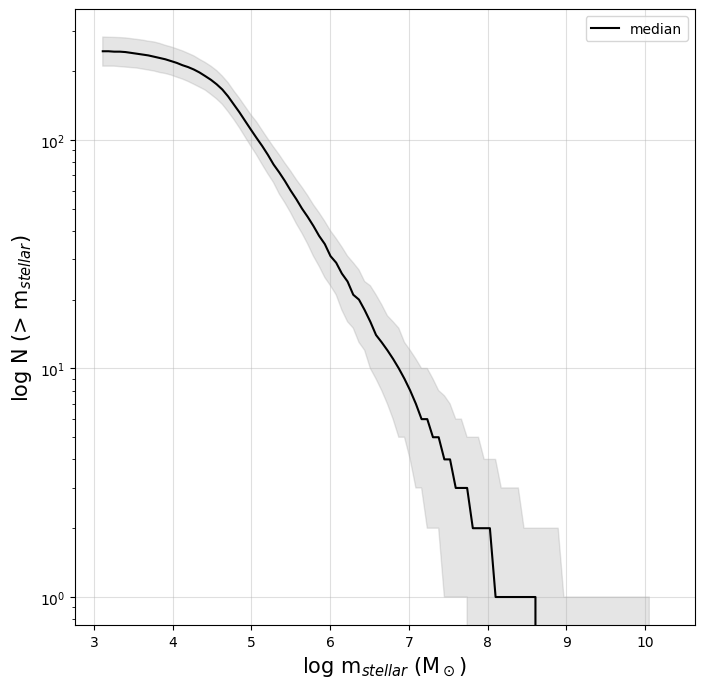

In [19]:
mass_range = np.linspace(np.nanmin(Ms), np.nanmax(Ms), 100)

I = np.zeros((Ms.shape[0], 100))

for i,realization in enumerate(Ms): #this double for loop can probably be replaced!
    for j,mass in enumerate(mass_range):
        I[i,j] = np.sum(realization > mass)
        
CSMF_quant = np.percentile(I, [5, 50, 95], axis=0) # the percentiles
        
plt.figure(figsize=(8, 8))

plt.plot(mass_range, CSMF_quant[1, :], label="median", color="black")
plt.fill_between(mass_range, y1=CSMF_quant[0, :], y2=CSMF_quant[2, :], alpha=0.2, color="grey")
plt.grid(alpha=0.4)
plt.yscale("log")
plt.xlabel("log m$_{stellar}$ (M$_\odot$)", fontsize=15)
plt.ylabel("log N (> m$_{stellar}$)", fontsize=15)
plt.legend()
plt.show()

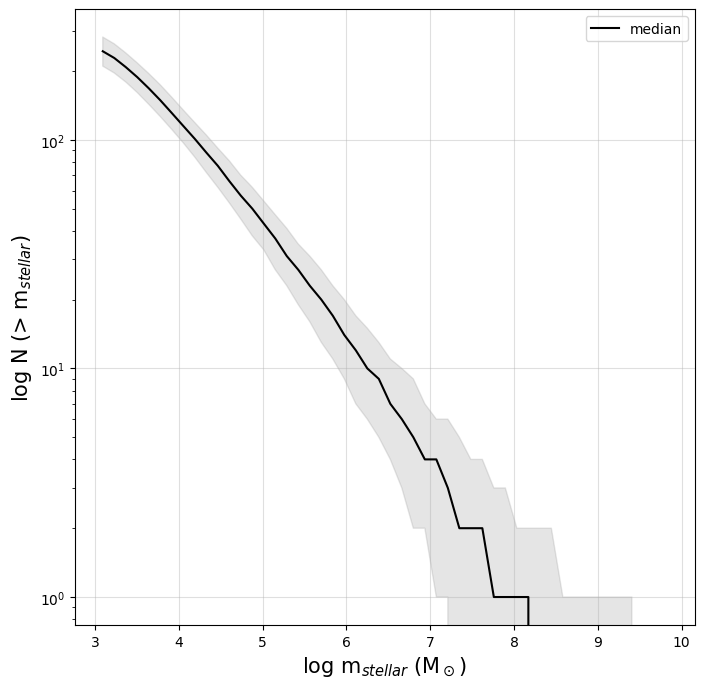

In [22]:
mass, quant = jsm_routines.CSMF(data)

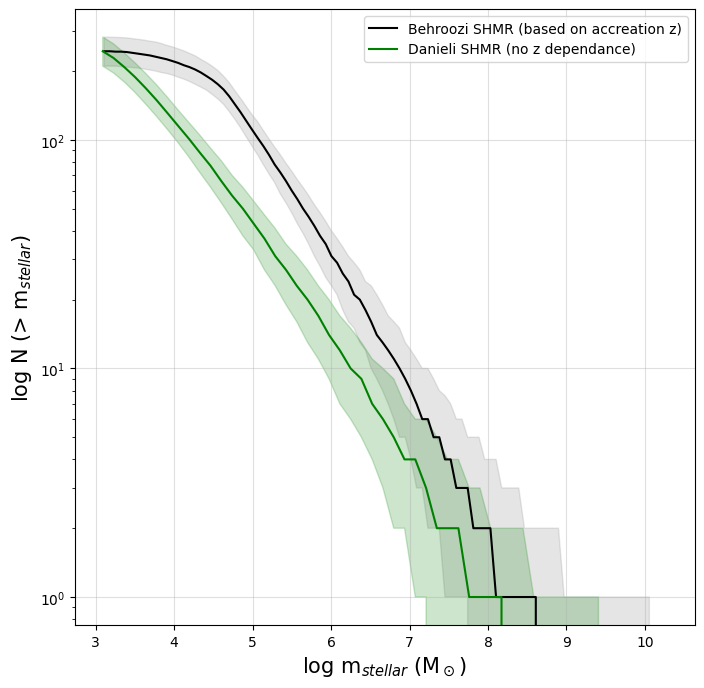

In [26]:
plt.figure(figsize=(8, 8))

plt.plot(mass_range, CSMF_quant[1, :], label="Behroozi SHMR (based on accreation z)", color="black")
plt.fill_between(mass_range, y1=CSMF_quant[0, :], y2=CSMF_quant[2, :], alpha=0.2, color="grey")

plt.plot(mass, quant[1, :], label="Danieli SHMR (no z dependance)", color="green")
plt.fill_between(mass, y1=quant[0, :], y2=quant[2, :], alpha=0.2, color="green")

plt.grid(alpha=0.4)
plt.yscale("log")
plt.xlabel("log m$_{stellar}$ (M$_\odot$)", fontsize=15)
plt.ylabel("log N (> m$_{stellar}$)", fontsize=15)
plt.legend()
plt.show()

/var/folders/91/ygwd64w5659_623tzhx80kbc0000gn/T/ipykernel_3270/326801359.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.plot(galhalo.lgMs_D22_det(10**xs), np.log10(ys), label="sorting + \nthe median mass range")
/var/folders/91/ygwd64w5659_623tzhx80kbc0000gn/T/ipykernel_3270/326801359.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.plot(mass, np.log10(quant[1]), label="no sorting + \nusing an evenly spaced mass range")
/var/folders/91/ygwd64w5659_623tzhx80kbc0000gn/T/ipykernel_3270/326801359.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.fill_between(mass, y1=np.log10(quant[0]), y2=np.log10(quant[2]), alpha=0.2, color="grey")


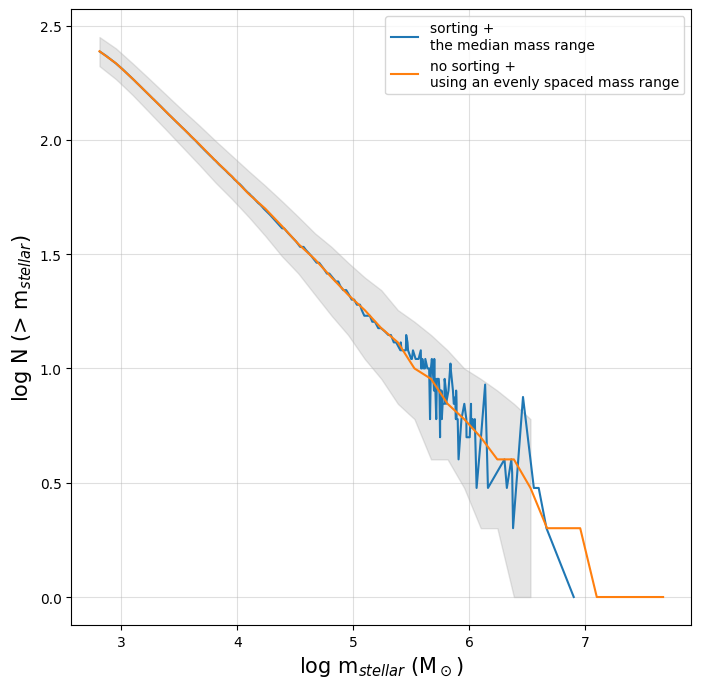

In [65]:
plt.figure(figsize=(8, 8))

plt.plot(galhalo.lgMs_D22_det(10**xs), np.log10(ys), label="sorting + \nthe median mass range")
plt.plot(mass, np.log10(quant[1]), label="no sorting + \nusing an evenly spaced mass range")
plt.fill_between(mass, y1=np.log10(quant[0]), y2=np.log10(quant[2]), alpha=0.2, color="grey")
plt.grid(alpha=0.4)
#plt.yscale("log")
#plt.xscale("log")
plt.xlabel("log m$_{stellar}$ (M$_\odot$)", fontsize=15)
plt.ylabel("log N (> m$_{stellar}$)", fontsize=15)
plt.legend()
plt.show()

In [ ]:
np.sum(~np.isnan(Mh[55]))

In [ ]:

Ms = galhalo.lgMs_D22_det(Mh)
mass_range = np.linspace(np.nanmin(Ms), np.nanmax(Ms), Npix)

#now converting to stellar mass, choice of scatter !
if scatter != False:
    Ms = galhalo.lgMs_D22_dex(Mh, scatter)

#now to start counting!
I = np.zeros((Ms.shape[0], Npix))

for i,realization in enumerate(Ms): #this double for loop can probably be replaced!
    for j,mass in enumerate(mass_range):
        I[i,j] = np.sum(realization > mass)
        

In [ ]:
np.nanmax(data_c)

In [ ]:
np.nanmin(data_c)

N =100

In [ ]:
mass_range = np.linspace(np.nanmin(data_c), np.nanmax(data_c), N)

In [ ]:
data_c[0,:]

In [ ]:
mat = np.zeros((data_c.shape[0], N))

for i,realization in enumerate(data_c):
    
    for j,mass in enumerate(mass_range):

        mat[i,j] = np.sum(realization > mass)

In [ ]:
SMF_quant = np.percentile(mat, [15, 50, 85], axis=0)

ave = np.average(mat, axis=0)

In [ ]:
SMF_quant[0]

In [ ]:
sat_range = galhalo.lgMs_D22_det(10**mass_range)

In [ ]:
galhalo.lgMs_D22_det(1e11)

In [ ]:
plt.plot(sat_range, np.log10(SMF_quant[1]))
plt.fill_between(sat_range, np.log10(SMF_quant[0]), np.log10(SMF_quant[2]), alpha=0.1)
#plt.plot(sat_range, np.log10(ave))
plt.grid(alpha=0.4)
plt.show()

In [ ]:
plt.plot(mass_range, np.log10(SMF_quant[1]))
plt.fill_between(mass_range, np.log10(SMF_quant[0]), np.log10(SMF_quant[2]), alpha=0.1)
plt.plot(mass_range, np.log10(ave))
plt.grid(alpha=0.4)
plt.show()

### Now trying to include a single value of sigma_SHMR

In [ ]:
test = galhalo.lgMs_D22_dex(10**data_c, dex=0.25)

In [ ]:
matt = np.zeros((data_c.shape[0], N))

for i,realization in enumerate(test):
    
    for j,mass in enumerate(sat_range):

        matt[i,j] = np.sum(realization > mass)

In [ ]:
SMF_quantt = np.percentile(matt, [15, 50, 85], axis=0)

In [ ]:
plt.figure(figsize=(8, 8))

plt.plot(sat_range, SMF_quantt[1])
plt.fill_between(sat_range, SMF_quantt[0],SMF_quantt[2], alpha=0.1)
plt.plot(sat_range,SMF_quant[1])
plt.fill_between(sat_range, SMF_quant[0], SMF_quant[2], alpha=0.1)
plt.yscale("log")
plt.grid(alpha=0.4)
plt.show()